In [43]:
import fcsparser as fcs
import os
import pandas as pd
import warnings
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.stats as stats
from scipy.optimize import curve_fit
from socket import gethostname
from itertools import product

sns.set(style="white")
sns.set_context("notebook")
warnings.filterwarnings("once")

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

tick_setup = {'labelsize' : SMALL_SIZE,
              'major.pad': 0}

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', **tick_setup)    # fontsize of the tick labels
plt.rc('ytick', **tick_setup)
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

hostname = gethostname().split('.')[0]
if hostname == 'Pluripa':
    home_dir = "/Users/weinberz/"
    box_dir = "/Users/weinberz/Box Sync/"
else:
    home_dir = "/Volumes/Coatamer/Users/weinberz/"
    box_dir = "/Volumes/Coatamer/Users/weinberz/Box/"

def gate_density (df, threshold):
    
    ymin = df['FSC-A'].min()
    ymax = df['FSC-A'].max()
    xmin = df['SSC-A'].min()
    xmax = df['SSC-A'].max()
                                                                                                                                
    #Perform a kernel density estimate on the data:
    df_mini = df.sample(1000)
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([df_mini['SSC-A'], df_mini['FSC-A']])
    kernel = stats.gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    cut = Z.max()*threshold
    
    # threhold dataframe
    df['gate'] = kernel([df['SSC-A'], df['FSC-A']])
    df2 = df[df.gate > cut]
    return df2

In [44]:
folders = [box_dir + 'BadIdea/Flow/20210202 - HexaPro LCB1 Time Course 24hr/',
           box_dir + 'BadIdea/Flow/20210203 - HexaPro LCB1 Time Course 48hr/',
           box_dir + 'BadIdea/Flow/20210204 - HexaPro LCB1 Time Course 72hr/']
outputdir = home_dir + "Google Drive/HES Lab/SARSNotch/SARSNotch Manuscript/jupyter_out/"

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
dfs = []
for folder in folders:
    ffolderlist = [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

    df=pd.DataFrame()
    aa=1
        #load all fcs files
    for fdn in ffolderlist:
        ffilelist = os.listdir(folder+fdn)
        for fn in ffilelist:
            filename, file_ext = os.path.splitext(fn)
            if file_ext ==".fcs":
                path = folder + fdn + "//" + fn
                meta, df1 = fcs.parse(path, meta_data_only=False, reformat_meta=True)
                df1["WellName"]=fn.split("_")[3].split(".")[0]
                df1["WellNumber"]= aa
                df=df.append(df1)
                aa=aa+1

    # metadata file
    meta = folder+ "metadata.csv"
    df1=pd.read_csv(meta, names=["WellName", "Sender", "Receiver",'Ratio','Timepoint','Replicate','Condition'])

    df=df1.merge(df, on=["WellName"])
    dfs.append(df)
    
df = pd.concat(dfs)

In [46]:
#remove small events
df2 =df[df["FSC-A"]>5E4]
df2 =df2[df2["SSC-A"]>2.5E4]

#remove NAs
df2= df2.loc[(df2.select_dtypes(include=['number']) > 0).all(axis='columns'), :]
df2=df2.dropna()

#gate cells
df2 = gate_density(df2, 0.1)

#log data
for col in df2.columns:
    if df2[col].dtype=="float32":
        df2["log"+ col]=df2[col].apply(math.log10)

In [47]:
df2.loc[df2['Receiver'] == 'LCB1-Notch', 'Receiver'] = 'SARSNotch'

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
qt90 = np.percentile(df2.loc[(df2['Receiver'] == 'No Notch') &
                             (df2['Sender'] == 'K562') &
                             (df2['Ratio'] == '1:1') &
                             (df2['logFITC-A'] > 4), 'logBV 421-A'], 90)
df_summary = (df2[(df2['logFITC-A'] > 4) &
                  (df2.Receiver.isin(['No Notch', 'SARSNotch']))]
 .groupby(['Sender','Receiver','Timepoint','Ratio', 'Replicate'])['logBV 421-A']
 .apply(lambda x: 100*np.sum(x>qt90)/len(x))
 .reset_index())

In [7]:
receivers = ['SARSNotch', 'No Notch']
senders = ['K562', 'Spike-K562']
colors = {'No Notch' : '#8C9696', 'SARSNotch' : '#4272B8'}
linestyles = {'K562' : ':', 'Spike-K562': '-'}

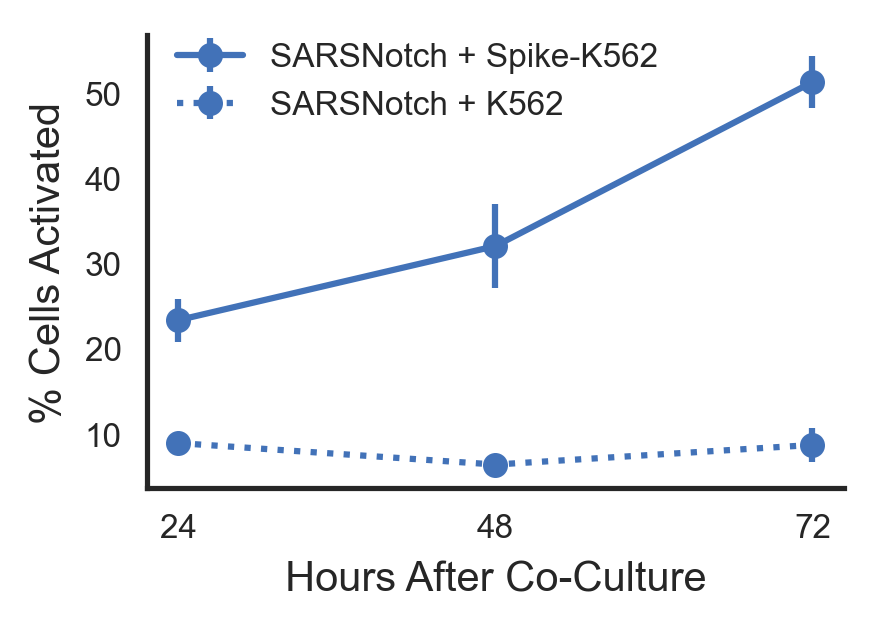

In [8]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for sender, receiver in product(senders, ['SARSNotch']):
    condition_summary = df_summary[(df_summary['Receiver']==receiver) & 
                                   (df_summary['Sender']==sender) &
                                   (df_summary['Ratio'] == '1:1')]
    output = (condition_summary
              .groupby('Timepoint')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index())
    ax.errorbar(output['Timepoint'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver], 
                label=f'{receiver} + {sender}',
                marker='.', markersize=10, ls=linestyles[sender])

ax.set_xlabel('Hours After Co-Culture')
ax.set_ylabel('% Cells Activated')
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [1, 0]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
sns.despine()
plt.savefig(outputdir + 'cell_cell_timecourse.svg')

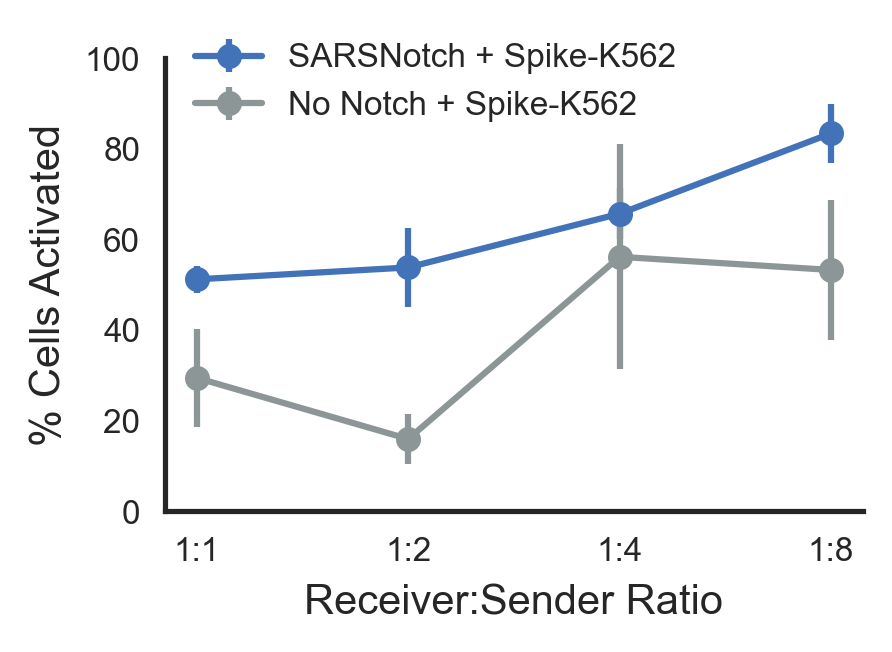

In [48]:
fig, ax = plt.subplots(1,1,figsize=(3,2), dpi=300)
for receiver in receivers:
    condition_summary = df_summary[(df_summary['Receiver']==receiver) & 
                                   (df_summary['Sender']=='Spike-K562') &
                                   (df_summary['Timepoint'] == '72')]
    output = (condition_summary
              .groupby('Ratio')['logBV 421-A']
              .agg([np.mean, np.std])
              .reset_index()
              .sort_values('Ratio', ascending=True))
    ax.errorbar(output['Ratio'], output['mean'], yerr=output['std'], 
                fmt='-', c=colors[receiver], 
                label=f'{receiver} + {sender}',
                marker='.', markersize=10, ls=linestyles[sender])

ax.set_xlabel('Receiver:Sender Ratio')
ax.set_ylabel('% Cells Activated')
plt.ylim([0,100])
plt.legend()
handles, labels = ax.get_legend_handles_labels()
order = [0,1]
plt.legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left', bbox_to_anchor=(0,1.1))
sns.despine()
plt.savefig(outputdir + 'cell_cell_nonspecific.svg')

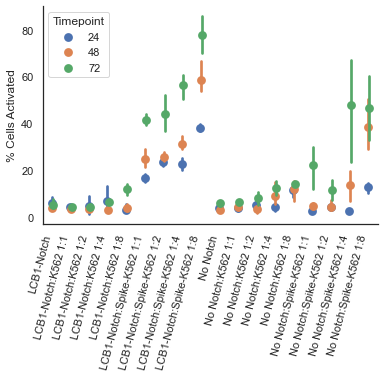

In [43]:
g = sns.pointplot(data=df_summary, x='Condition', y='logBV 421-A', hue='Timepoint', join=False, dodge=True)
g.set_xlabel('')
g.set_ylabel('% Cells Activated')
plt.xticks(rotation=75, ha='right')
sns.despine()